In [ ]:
## Kyle Model

These exercises are intended to help you use the Kyle model to understand the orderbooks
of 5 tickers on a particular day (July 11, 2017). The data have been compiled from the
NASDAQ ITCH data files for those days.

In [6]:
# Standard Imports

import pandas as pd
import numpy as np
import pickle
import scipy.stats as sts
import matplotlib.pyplot as plt

In [7]:
# Standard Data upload

files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []

for file in files:
    with open('data/' + file, 'rb') as pickle_file:
        file_objs.append(pickle.load(pickle_file))

### Class for orderbook.

In [9]:
class OrderBook:
    """
    Class for orderbook with standardised attributes 
    
        
    """
    
    def __init__(self, data, lower, upper):
        """
        Standardised attributes.
        
        """
        self.data = data[1]
        self.time = data[0]
        self.lower = lower
        self.upper = upper
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        # Drop unseeded data here
        df.columns = ['Quantity', 'Type', 'na','naa']
        df = df.drop(['na', 'naa'], axis = 1)
        
        # price deternination using supply and demand
        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        # Equilibrium using supply and demand
        orders = pd.concat([self.demand, self.supply], sort=True)
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        self.midpoint = orders[orders.Q < 0].index.values[0]
        
        # localise interval
        self.orders = orders[(orders.index > lower * self.midpoint) 
                             & (orders.index < upper * self.midpoint)]
        
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def estimate(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.p = - self.gamma/self.beta
        self.ratio = self.beta    

    def plot_orderbook(self, name):
        fig = plt.figure(figsize=(10,7))
        plt.plot(self.demand.index.values, self.demand['QD'], label='Quantity Demanded')
        plt.plot(self.supply.index.values, self.supply['QS'], label='Quantity Supplied')
        p_grid = np.linspace(self.lower * self.midpoint, self.upper * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'r', label='Estimated Equation')
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(name + ' Stock at t = %i' %self.time)
        plt.legend()
        plt.show()
        
    def compare(self):
        print("The estimated p_0 is: %f" %self.p)
        print("The actual midpoint of the BBO is: %f" %self.midpoint)
        

### Plot orderbooks and estimated equations

The orderbook model fits well locally around the points where demand eqauls supply. As one moves away fro them, the fit worsens.

In [10]:
def show_orderbook(file_obj, t, name):
    test = OrderBook(file_obj[t], .9, 1.1)
    test.estimate()
    test.plot_orderbook(name)
    test.compare()

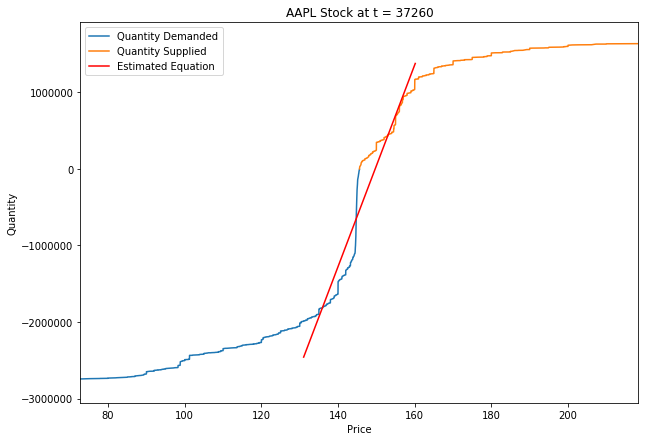

The estimated p_0 is: 149.686787
The actual midpoint of the BBO is: 145.580000


In [12]:
show_orderbook(file_objs[0], 50, 'AAPL') #Smooth approximation

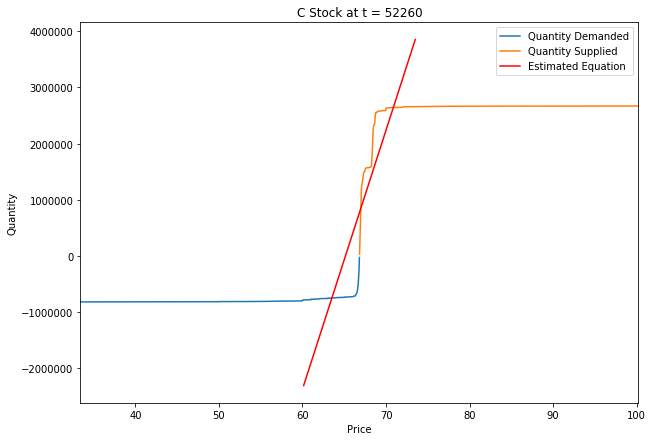

The estimated p_0 is: 65.141571
The actual midpoint of the BBO is: 66.820000


In [13]:
show_orderbook(file_objs[1], 300, 'C')

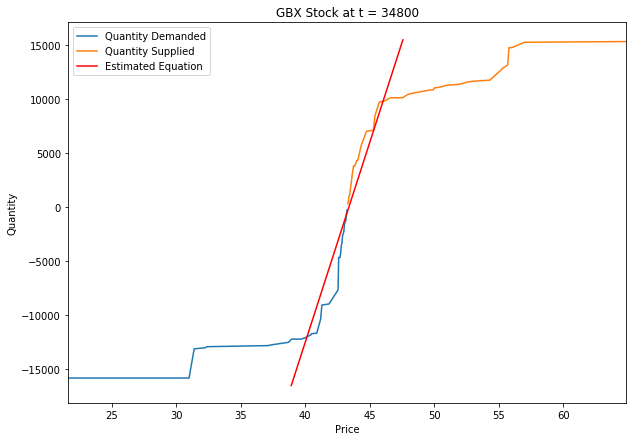

The estimated p_0 is: 43.393255
The actual midpoint of the BBO is: 43.250000


In [14]:
show_orderbook(file_objs[2], 9, 'GBX')

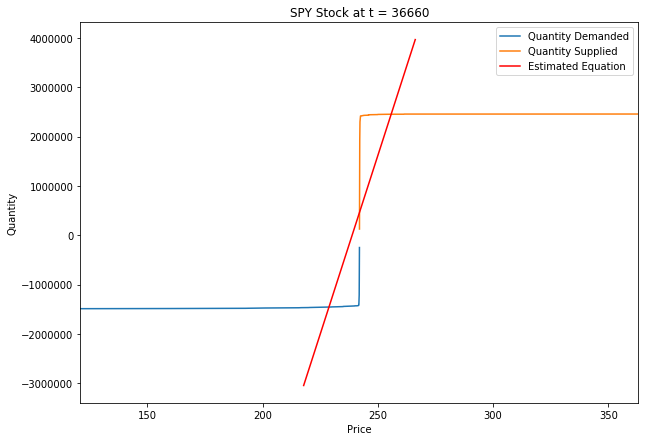

The estimated p_0 is: 238.868532
The actual midpoint of the BBO is: 242.040000


In [15]:
show_orderbook(file_objs[3], 40, 'SPY')

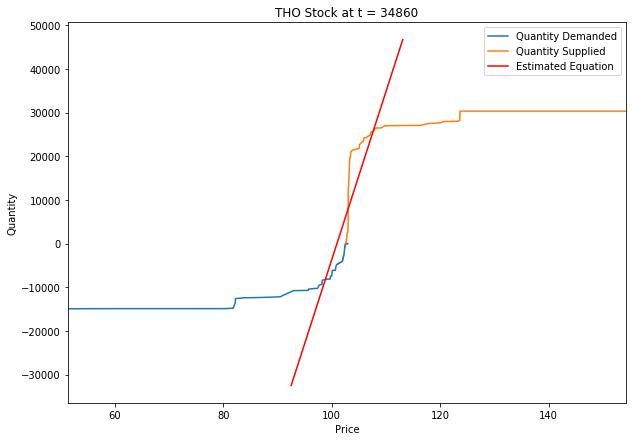

The estimated p_0 is: 100.966398
The actual midpoint of the BBO is: 102.810000


In [17]:
show_orderbook(file_objs[4], 10, 'THO') #gradual worsening of the fit

### 2. For each ticker, plot estimated value of $\frac{2\sigma_u}{\sqrt{\Sigma_0}}$  throughout the day

 Changes in the slope of the orderbook relate to changes in market maker beliefs about the ratio $\frac{2\sigma_u}{\sqrt{\Sigma_0}}$. Thus, changes in the BBO reflect (according to this model) changes in the value of the asset directly, whereas changes in the slope reflect changes in the relative volatility of trade between informed and
uninformed traders.Changes in $\frac{2\sigma_u}{\sqrt{\Sigma_0}}$ reflect changes in the relative volatility of trade between informed and uniformed traders.

In [18]:
def plot_ratio(file_obj, title):
    ratio = np.zeros(len(file_obj), dtype=np.float64)
    for ii in range(len(file_obj)):
        book = OrderBook(file_obj[ii], .9, 1.1)
        book.estimate()
        ratio[ii] = book.ratio
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(ratio)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(r'$\frac{2\sigma_u}{\sqrt{\Sigma_0}}$')
    plt.show()

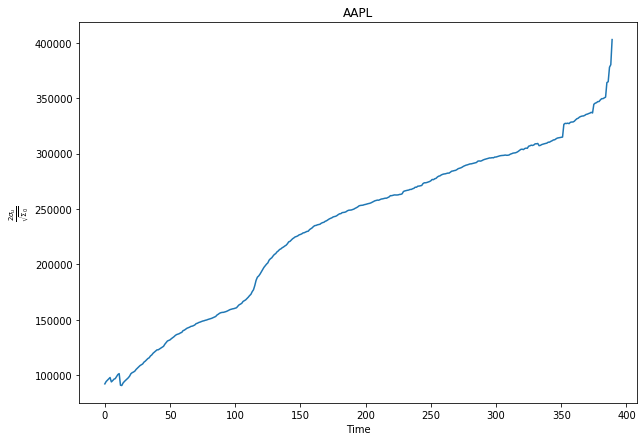

In [19]:
plot_ratio(file_objs[0], 'AAPL')

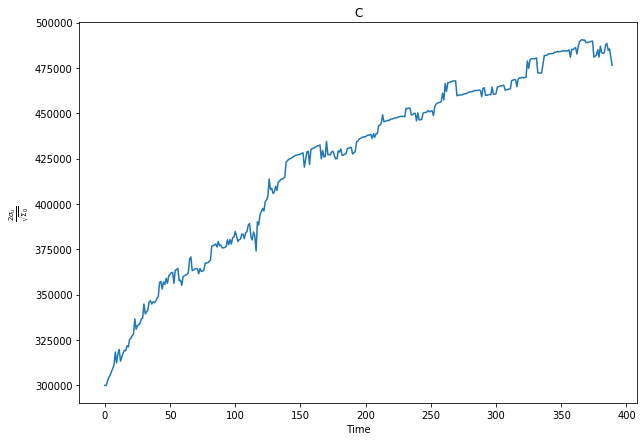

In [20]:
plot_ratio(file_objs[1], 'C')

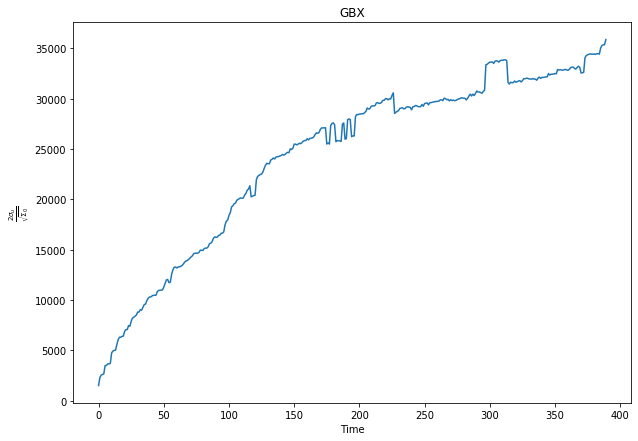

In [21]:
plot_ratio(file_objs[2], 'GBX')

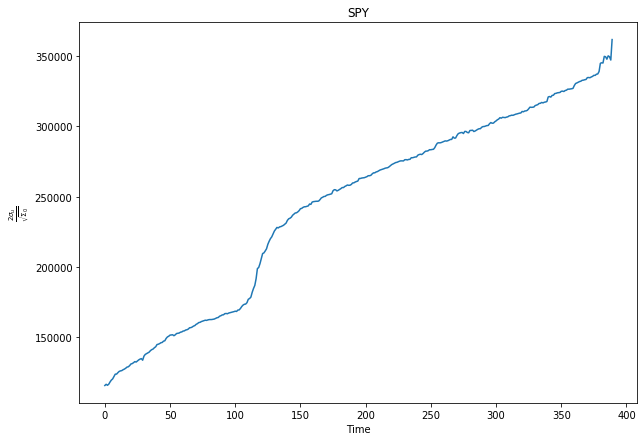

In [22]:
plot_ratio(file_objs[3], 'SPY')

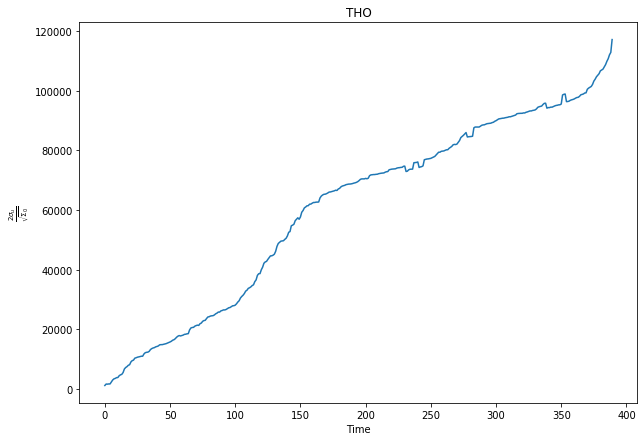

In [23]:
plot_ratio(file_objs[4], 'THO')

### Compare estimates of $p_0$ to the actual midpoint of the BBO over time

In [24]:
def comparison_p(file_obj, title, cutval=1):
    p_est = np.zeros(len(file_obj), dtype=np.float64)
    p_act = np.zeros(len(file_obj), dtype=np.float64)
    for ii in range(len(file_obj)):
        book = OrderBook(file_obj[ii], .9, 1.1)
        book.estimate()
        p_est[ii] = book.p
        p_act[ii] = book.midpoint
    
    fig = plt.figure(figsize=(8,5))
    plt.plot(p_est - p_act, label=r'$\hat{p}_0 - p_0$')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'Difference')
    plt.show()
    
    fig = plt.figure(figsize=(8,5))
    plt.plot(p_est, label='Estimated p')
    plt.plot(p_act, label='Actual p')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'$p$')
    plt.show()
    
    

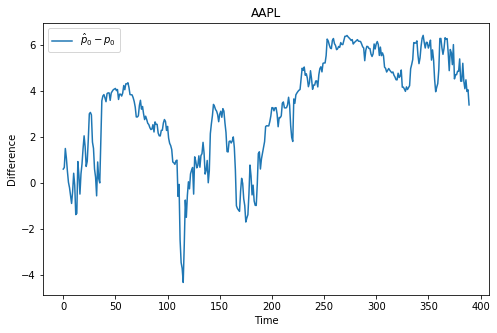

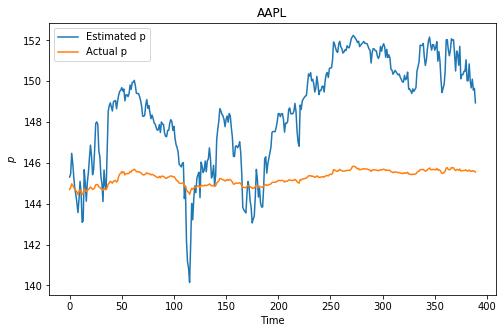

In [25]:
comparison_p(file_objs[0], 'AAPL')

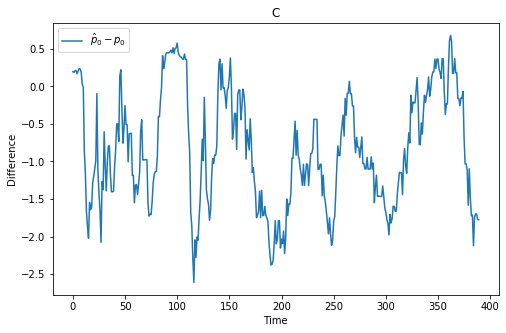

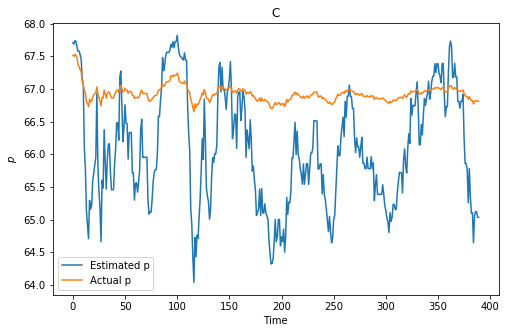

In [27]:
comparison_p(file_objs[1], 'C')

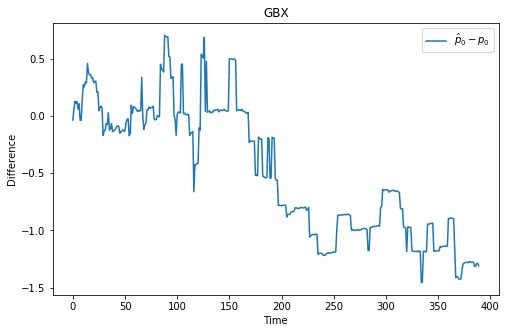

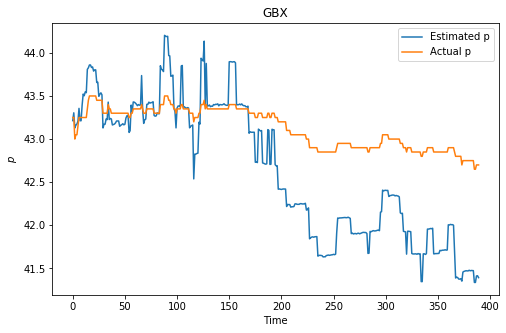

In [28]:
comparison_p(file_objs[2], 'GBX')

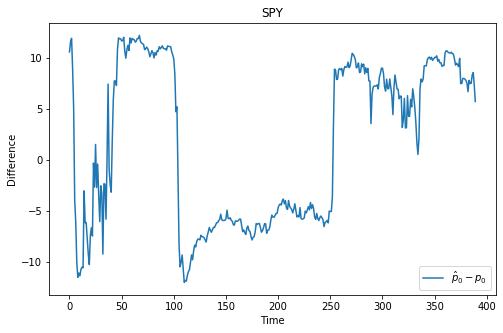

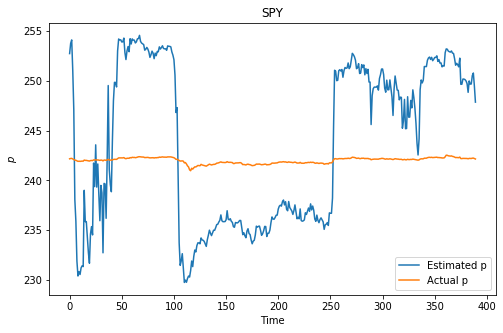

In [29]:
comparison_p(file_objs[3], 'SPY')

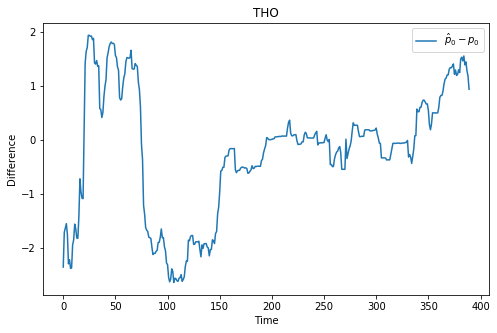

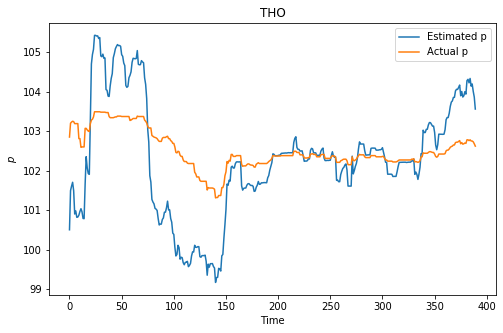

In [30]:
comparison_p(file_objs[4], 'THO')

This shows how sensitivethe estimation procedure is to time steps and therefore, a more careful analysis and inference is always desired everytime one does this exercise.

Following the logic above, one expects the tickers with more volatility to have worse estimated $p_0$ values. Consider the AAPL and C stocks -- noise signal ratio turns out to be smoother for AAPL and bumpier for C. We observe that the estimated $p_0$ for C does not pick up on much of this volatility.

In [31]:
## Thank You